In [1]:
import pandas as pd

In [4]:
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, select
from dotenv import load_dotenv
import os

In [3]:
load_dotenv()

DB_PASS = os.getenv("DB_PASS")
DB_USER = os.getenv("DB_USER")
DB_HOST = os.getenv("DB_HOST")

engine = create_engine(f"mysql://{DB_USER}:{DB_PASS}@{DB_HOST}/options")

In [20]:
options = pd.read_sql('options_data', engine)

In [21]:
options['date'] = options['pull_timestamp'].apply(lambda x: x.date())

In [29]:
options['date']

0        2020-12-18
1        2020-12-18
2        2020-12-18
3        2020-12-18
4        2020-12-18
            ...    
44129    2021-01-04
44130    2021-01-04
44131    2021-01-04
44132    2021-01-04
44133    2021-01-04
Name: date, Length: 44134, dtype: object

In [44]:
expiration_prices = options[(options['days_to_expiry'] == 0)][['expiry', 'ticka', 'close_on_pull', 'strike', 'contract']].copy()

In [45]:
expiration_prices

,expiry,ticka,close_on_pull,strike,contract
0,2020-12-18,SHOP,1170.96,860.0,P
1,2020-12-18,SHOP,1170.96,865.0,P
2,2020-12-18,SHOP,1170.96,875.0,P
3,2020-12-18,SHOP,1170.96,880.0,P
4,2020-12-18,SHOP,1170.96,890.0,P
...,...,...,...,...,...
37718,2020-12-31,ADBE,500.12,590.0,C
37719,2020-12-31,ADBE,500.12,600.0,C
37720,2020-12-31,ADBE,500.12,610.0,C
37721,2020-12-31,ADBE,500.12,620.0,C


In [46]:
def assignement(row):
    if row['contract'] == 'P':
        if row['strike'] < row['close_on_pull']:
            return 1
        else:
            return 0
    if row['contract'] == 'C':
        if row['strike'] > row['close_on_pull']:
            return 1
        else:
            return 0
    #otherwise
    return -1

expiration_prices['assigned'] = expiration_prices.apply(assignement, axis = 1)
expiration_prices

,expiry,ticka,close_on_pull,strike,contract,assigned
0,2020-12-18,SHOP,1170.96,860.0,P,1
1,2020-12-18,SHOP,1170.96,865.0,P,1
2,2020-12-18,SHOP,1170.96,875.0,P,1
3,2020-12-18,SHOP,1170.96,880.0,P,1
4,2020-12-18,SHOP,1170.96,890.0,P,1
...,...,...,...,...,...,...
37718,2020-12-31,ADBE,500.12,590.0,C,1
37719,2020-12-31,ADBE,500.12,600.0,C,1
37720,2020-12-31,ADBE,500.12,610.0,C,1
37721,2020-12-31,ADBE,500.12,620.0,C,1


In [11]:
bands = pd.read_sql('band_data', engine)

In [25]:
bands.rename(columns={'ticker':'ticka'}, inplace=True)

In [31]:
bands['date'] = bands['date'].apply(lambda x: x.date())

In [33]:
options = options.merge(bands.drop(columns=['adjclose']), on=['date','ticka'])

In [48]:
options = options.merge(expiration_prices.drop(columns=['close_on_pull']), on=['expiry', 'ticka', 'strike', 'contract'])

In [54]:
def mark_safe(row):
    if row['contract'] == 'P':
        if row['strike'] < row['lower']:
            return 1
        else:
            return 0
    if row['contract'] == 'C':
        if row['strike'] > row['upper']:
            return 1
        else:
            return 0

In [57]:
options['SD_to_MA'] = options['STD']/options['MA']
options['pct_MA_to_adj'] = ((options['close_on_pull']/options['MA'])-1).apply(lambda x: abs(x))
options['pct_adj_to_strike'] = ((options['strike']/options['close_on_pull'])-1).apply(lambda x: abs(x))

In [58]:
options.to_csv('two_months_options.csv')

In [59]:
options.columns

Index(['contract_name', 'last_trade_date', 'strike', 'last_price', 'bid',
       'ask', 'change', 'pct_change', 'volume', 'open_interest',
       'implied_volatility', 'contract', 'pull_timestamp', 'expiry',
       'days_to_expiry', 'close_on_pull', 'ticka', 'date', 'MA', 'STD',
       'Upper', 'Lower', 'assigned', 'SD_to_MA', 'pct_MA_to_adj',
       'pct_adj_to_strike'],
      dtype='object')

In [53]:
from sklearn.model_selection import train_test_split

In [60]:
trainX, validX, trainY, validY = train_test_split(options[['implied_volatility', 'days_to_expiry', 'MA', 'STD', 'SD_to_MA', 'pct_MA_to_adj', 'pct_adj_to_strike']], options['assigned'], test_size=0.15, random_state=42)

In [61]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
def plot_metric(clf, testX, testY, name):
    """
    Small function to confusion matrix
    """
    plt.style.use('ggplot')
    plot_confusion_matrix(clf, testX, testY, normalize='true')
    plt.title(f"Confusion Matrix [{name}]")

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(trainX, trainY)
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Random Forest Classifier is: 89.49%


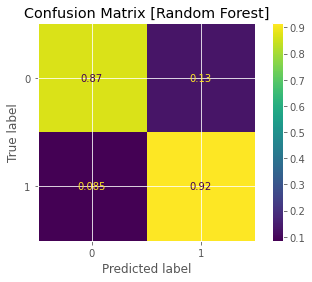

In [63]:
plot_metric(rf_classifier, validX, validY, "Random Forest")

In [64]:
rf_classifier.feature_importances_

array([0.57729026, 0.0178525 , 0.0370047 , 0.03084088, 0.03156765,
       0.02948788, 0.27595613])